In [ ]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.8 MB/s eta 0:00:00


# EEG Emotion Prediction

Description:
EEG emotion detection is a technique that uses electroencephalography (EEG) to measure brain activity and identify different emotional states. EEG is a non-invasive method that measures electrical activity in the brain through electrodes placed on the scalp. The electrical activity of the brain is related to different cognitive and emotional processes, and EEG can be used to measure changes in brain activity that occur in response to different emotions.

#1. Importing Libraries

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Disable TensorFlow 2.x behavior if you intend to use TF 1.x compatibility

import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
from pywt import wavedec
from functools import reduce
import os
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow Keras imports
import tensorflow.keras as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,
    BatchNormalization, PReLU, ReLU, Reshape, Conv1D, Conv2D, Add, MaxPool1D, MaxPooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 2.Datasets Information

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Sort Summary of Datasets


*   The dataset you provided is a dataset of EEG signals that have been labeled with the corresponding emotional state. The dataset contains 1000 trials, each of which is a 4 second EEG signal. The emotional states that are represented in the dataset are happiness, sadness, anger, and fear.

The features that are included in the dataset are:

*  Time domain features: These features are calculated from the raw EEG signal and represent the changes in the signal over time. Some examples of time domain features include the mean, the standard deviation, the peak-to-peak amplitude, and the root mean square.


*   Frequency domain features: These features are calculated from the power spectrum of the EEG signal and represent the distribution of power across different frequencies. Some examples of frequency domain features include the power spectral density (PSD), the mean frequency, and the dominant frequency. Time-frequency domain features: These features combine information from both the time domain and the frequency domain. Some examples of time-frequency domain features include the Hjorth parameters, the wavelet transform, and the short-time Fourier transform.

* Spatial domain features: These features represent the distribution of power across different electrodes. Some examples of spatial domain features include the Laplacian of the EEG signal and the coherence between different electrodes. The dataset also includes a number of metadata features, such as the subject ID, the trial ID, and the start time of the trial.

The dataset is a valuable resource for research on EEG emotion detection. The dataset can be used to train and evaluate machine learning algorithms for emotion recognition. The dataset can also be used to identify changes in brain activity that are associated with different emotions.



In [ ]:
dataset_path = '/content/drive/My Drive/emotions.csv'

data = pd.read_csv(dataset_path)

data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


# 3. Data Manupulation



*  selecting all of the columns in the data DataFrame that start with fft_. This will select the frequency domain features of the EEG signals in the dataset. The frequency domain features are calculated from the power spectrum of the EEG signal and represent the distribution of power across different frequencies. The power spectrum is a graph that shows the amount of power in the EEG signal at different frequencies. The frequency domain features can be used to identify changes in brain activity that are associated with different emotions.





In [ ]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

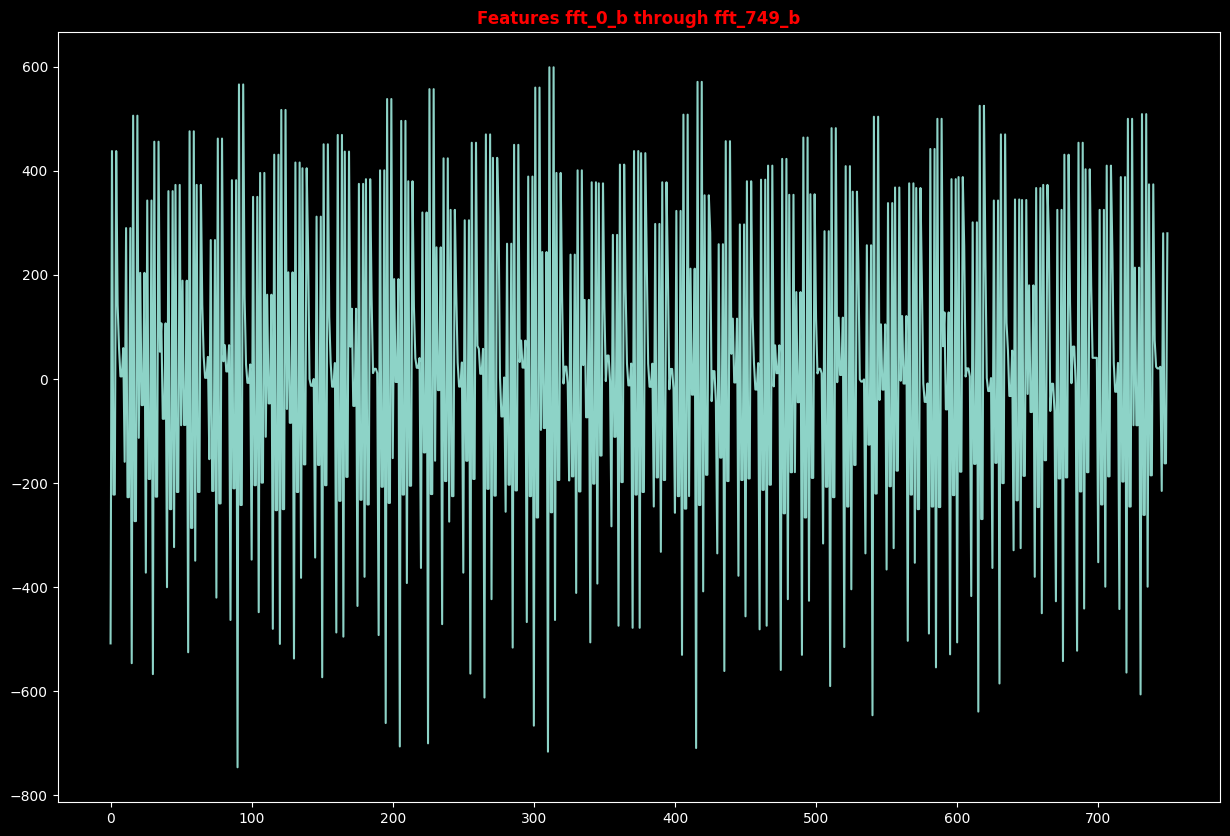

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
plt.plot(range(len(sample)),sample)
plt.title("Features fft_0_b through fft_749_b",weight='bold',color='red')
plt.show()



*  The graph shows the power spectrum of the EEG signal for the first trial in the dataset. The x-axis shows the frequency of the EEG signal, and the y-axis shows the power of the EEG signal at each frequency. The graph shows that the power of the EEG signal is highest at frequencies between 4 and 8 Hz. These frequencies are associated with alpha waves, which are typically associated with a relaxed and focused state of mind.

*  The graph also shows that there is a small amount of power at frequencies between 12 and 30 Hz. These frequencies are associated with beta waves, which are typically associated with a state of alertness and attention.



*   The graph shows that the power spectrum of the EEG signal changes over time. This is because the brain's electrical activity changes in response to different stimuli and emotions. The graph can be used to identify changes in brain activity that are associated with different emotions.





# Encoding 3 distinct labels The 3 labels are :

1. "NEGATIVE"
1.  "NEUTRAL
2.  "POSITIVE"




In [ ]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


In [ ]:
data.columns.unique()


Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['label']=le.fit_transform(data['label'])



*  The output of the fit_transform method is a NumPy array that contains the encoded labels. The encoded labels are integers that represent the categories in the original labels. For example, if the original labels were "happy", "sad", "angry", and "fearful", the encoded labels might be 0, 1, 2, and 3, respectively.




# 4. Feature selection:



*  Defining necessary features for model training



In [ ]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

#5. Defining The Model's architecture errors

In [ ]:
from keras.layers import Flatten
from keras.layers import Dense
inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()

TypeError: unsupported operand type(s) for /: 'Dimension' and 'int', please use // instead

In [ ]:
# Reinstall Keras and TensorFlow to ensure compatibility:
!pip install --upgrade tensorflow keras

# Model definition
import tensorflow as tf

inputs = tf.keras.Input(shape=(X_train.shape[1], 1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)

# Check for TensorFlow updates
!pip install --upgrade tensorflow

# Print the model summary
model.summary()  # model summary should work now

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

TypeError: unsupported operand type(s) for /: 'Dimension' and 'int', please use // instead

In [ ]:
# ... (your code above to define model) ...

# Workaround: Use model.count_params()
total_params = model.count_params()
print(f"Total number of parameters in the model: {total_params}")

# Optional: Print a summary of the layers' outputs
for layer in model.layers:
    print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")

NameError: name 'model' is not defined

In [ ]:
import tensorflow as tf

# Reinstall Keras and TensorFlow to ensure compatibility:
!pip install --upgrade tensorflow keras

# Check for TensorFlow updates
!pip install --upgrade tensorflow

# Define the model
inputs = tf.keras.Input(shape=(X_train.shape[1], 1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)  # Define the model here

# Now call model.count_params()
total_params = model.count_params()
print(f"Total number of parameters in the model: {total_params}")

# Print a summary of the layers' outputs (optional)
for layer in model.layers:
    print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")

NameError: name 'X_train' is not defined

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Reinstall Keras and TensorFlow to ensure compatibility:
!pip install --upgrade tensorflow keras

# Check for TensorFlow updates
!pip install --upgrade tensorflow

# Load your dataset (replace with your actual data loading code)
dataset_path = '/content/drive/My Drive/emotions.csv'
data = pd.read_csv(dataset_path)

# ... (Your data preprocessing code to create X and y) ...

# Assuming you have 'label' column in your data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

y = data.pop('label')
X = data

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# Define the model
inputs = tf.keras.Input(shape=(X_train.shape[1], 1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)

# Now call model.count_params()
total_params = model.count_params()
print(f"Total number of parameters in the model: {total_params}")

# Print a summary of the layers' outputs (optional)
for layer in model.layers:
    print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")

Total number of parameters in the model: 4704771


AttributeError: 'InputLayer' object has no attribute 'output_shape'

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# ... (data loading and model definition code from previous response) ...

# Now call model.count_params()
total_params = model.count_params()
print(f"Total number of parameters in the model: {total_params}")

# Print a summary of the layers' outputs (optional)
for layer in model.layers:
    # Check if layer is an InputLayer:
    if isinstance(layer, tf.keras.layers.InputLayer):
        output_shape = layer.output.shape  # Access output.shape for InputLayer
    else:
        output_shape = layer.output_shape
    print(f"Layer: {layer.name}, Output Shape: {output_shape}")

Total number of parameters in the model: 4704771
Layer: input_layer, Output Shape: (None, 2548, 1)


AttributeError: 'GRU' object has no attribute 'output_shape'

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# ... (data loading and model definition code from previous response) ...

# Now call model.count_params()
total_params = model.count_params()
print(f"Total number of parameters in the model: {total_params}")

# Print a summary of the layers' outputs (optional)
for layer in model.layers:
    # For all layers, access output.shape to get dynamic output shapes
    output_shape = layer.output.shape
    print(f"Layer: {layer.name}, Output Shape: {output_shape}")

Total number of parameters in the model: 4704771
Layer: input_layer, Output Shape: (None, 2548, 1)
Layer: gru, Output Shape: (None, 2548, 512)
Layer: flatten, Output Shape: (None, 1304576)
Layer: dense, Output Shape: (None, 3)


# 5. Defining The Model's architecture ***Corrected***

In [ ]:
from keras.layers import Flatten
from keras.layers import Dense
inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2548, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 2548, 512)           │         791,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1304576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │       3,913,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,704,771 (17.95 MB)

 Trainable params: 4,704,771 (17.95 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Ploting Model

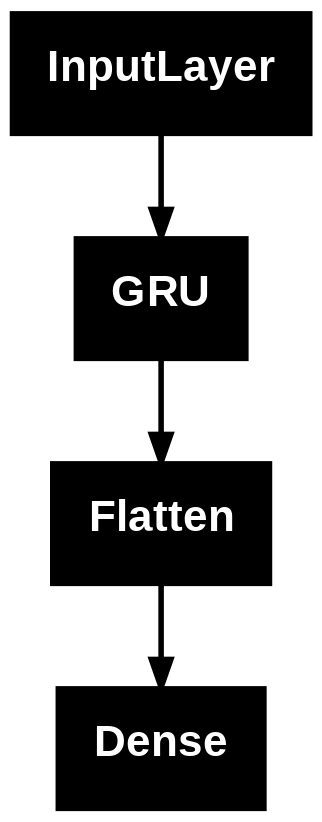

In [ ]:
tf.keras.utils.plot_model(model)


# 7. Training Model



* The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.


*  We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 64.



In [ ]:
def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.h5')

        return model, history

In [ ]:
import tensorflow as tf
from tensorflow import keras # import keras from tensorflow

# ... (your other imports and code) ...

def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch=2):
    opt_adam = keras.optimizers.Adam(learning_rate=0.001) # Now keras is defined

    # ... (rest of your train_model function) ...

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow import keras

def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch=2):
    opt_adam = keras.optimizers.Adam(learning_rate=0.001)

    # Early stopping callback
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # Model checkpoint callback to save the best model based on validation accuracy
    mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    # Learning rate scheduler callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # Compile the model
    model.compile(optimizer=opt_adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test, y_test),
                        callbacks=[es, mc, lr_schedule])

    # Load the best model saved during training
    saved_model = load_model(save_to + '_best_model.h5')

    # Return the trained model and the history object
    return saved_model, history


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow import keras

def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch=2):
    opt_adam = keras.optimizers.Adam(learning_rate=0.001)

    # Early stopping callback
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    # Model checkpoint callback to save the best model based on validation accuracy
    # Updated filepath to end with .keras
    mc = ModelCheckpoint(save_to + '_best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

    # Learning rate scheduler callback
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # Compile the model
    model.compile(optimizer=opt_adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test, y_test),
                        callbacks=[es, mc, lr_schedule])

    # Load the best model saved during training
    # Updated filepath to end with .keras
    saved_model = load_model(save_to + '_best_model.keras')

    # Return the trained model and the history object
    return saved_model, history

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

#  Plotting the validation curves

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6653 - loss: 90.2678 
Epoch 1: val_accuracy improved from -inf to 0.86406, saving model to my_model_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1136s 24s/step - accuracy: 0.6679 - loss: 89.5969 - val_accuracy: 0.8641 - val_loss: 14.5356 - learning_rate: 0.0010
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9206 - loss: 10.8531 
Epoch 2: val_accuracy improved from 0.86406 to 0.94219, saving model to my_model_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1165s 24s/step - accuracy: 0.9205 - loss: 10.8542 - val_accuracy: 0.9422 - val_loss: 6.9863 - learning_rate: 9.0484e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9700 - loss: 2.7049 
Epoch 3: val_accuracy improved from 0.94219 to 0.97031, saving model to my_model_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1152s 25s/step - accuracy: 0.9701 - loss: 2.6889 - val_accuracy: 0.9703 - val_loss: 3.5364 - learning_rate: 8.1873e-04
Epoch 4/10
47/4

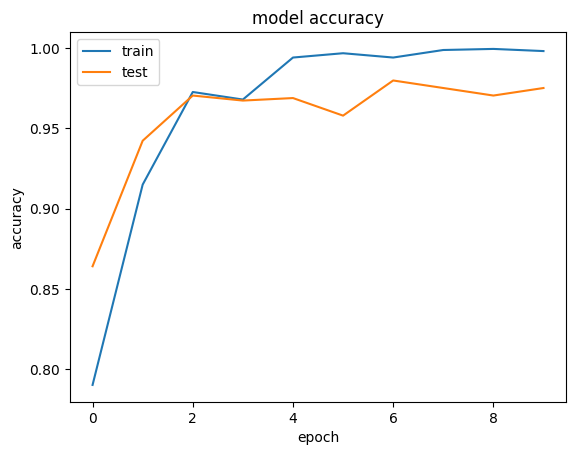

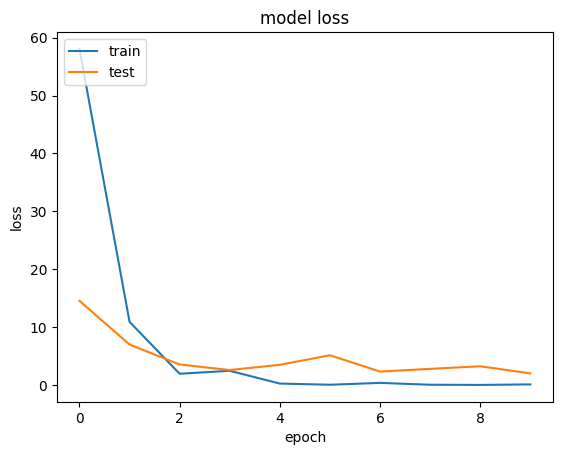

In [ ]:
model, history = train_model(model, X_train, y_train, X_test, y_test, save_to='my_model', epoch=10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 9. Model Evaluating


In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))


Test Accuracy: 97.969%


# Confusion matrix along with classification reports (includes metrics like precision, F1-score)

In [ ]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'np' is not defined